### Loading the dataset

In [1]:
import pandas as pd

olist_orders_dataset_df = pd.read_csv('temp/olist_orders_dataset_df.csv')


In [2]:
X = olist_orders_dataset_df.drop(['anomaly'], axis=1)

### Normalizing

In [3]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X = qt.fit_transform(X)


### Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [5]:
df = pd.DataFrame(X)
df = pd.concat([df, olist_orders_dataset_df['anomaly']], axis=1)


### Splitting the dataset

In [6]:
# Separate the records based on the label
normal_records = df[df['anomaly'] == False]
anomaly_records = df[df['anomaly'] == True]

# Randomly sample an equal number of False records
normal_records_sampled = normal_records.sample(n=len(anomaly_records))

# First DataFrame: Equal number of True and False records
df_test = pd.concat([anomaly_records, normal_records_sampled]).sample(frac=1).reset_index(drop=True)

# Second DataFrame: Remaining False records
df_remaining_normal = normal_records.drop(normal_records_sampled.index).reset_index(drop=True)


In [14]:
X_anomaly = anomaly_records.drop(['anomaly'], axis=1).to_numpy()
X_test = df_test.drop(['anomaly'], axis=1).to_numpy()
y_test = df_test['anomaly'].to_numpy()
X_normal = df_remaining_normal.drop(['anomaly'], axis=1).to_numpy()


### Import Necessary Libraries:

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


### Define the Autoencoder Architecture

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(18, 14),  # Assuming the first hidden layer has 12 nodes
            nn.ReLU(),
            nn.Linear(14, 10),   # Further compressing to 8 nodes
            nn.ReLU(),
            nn.Linear(10, 6)
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(6, 10),
            nn.ReLU(),
            nn.Linear(10, 14),
            nn.ReLU(),
            nn.Linear(14, 18),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Instantiate the Model, Loss Function, and Optimizer

In [10]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


### Convert DataFrame to PyTorch Tensor

In [11]:
tensor_data_test = torch.Tensor(X_test)
tensor_data_normal = torch.Tensor(X_normal)
tensor_data_anomaly  = torch.Tensor(X_anomaly)

### DataLoader

In [12]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(tensor_data_normal)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


### Training Loop

In [13]:
# Example training loop
num_epochs = 300
for epoch in range(num_epochs):
    for batch_features, in train_loader:  # DataLoader will unpack the features
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/300], Loss: 0.0137
Epoch [2/300], Loss: 0.0068
Epoch [3/300], Loss: 0.0090
Epoch [4/300], Loss: 0.0120
Epoch [5/300], Loss: 0.0078
Epoch [6/300], Loss: 0.0061
Epoch [7/300], Loss: 0.0094
Epoch [8/300], Loss: 0.0085
Epoch [9/300], Loss: 0.0076
Epoch [10/300], Loss: 0.0085
Epoch [11/300], Loss: 0.0065
Epoch [12/300], Loss: 0.0098
Epoch [13/300], Loss: 0.0075
Epoch [14/300], Loss: 0.0087
Epoch [15/300], Loss: 0.0093
Epoch [16/300], Loss: 0.0078
Epoch [17/300], Loss: 0.0111
Epoch [18/300], Loss: 0.0097
Epoch [19/300], Loss: 0.0082
Epoch [20/300], Loss: 0.0086
Epoch [21/300], Loss: 0.0072
Epoch [22/300], Loss: 0.0052
Epoch [23/300], Loss: 0.0088
Epoch [24/300], Loss: 0.0058
Epoch [25/300], Loss: 0.0087
Epoch [26/300], Loss: 0.0061
Epoch [27/300], Loss: 0.0063
Epoch [28/300], Loss: 0.0093
Epoch [29/300], Loss: 0.0072
Epoch [30/300], Loss: 0.0042
Epoch [31/300], Loss: 0.0054
Epoch [32/300], Loss: 0.0076
Epoch [33/300], Loss: 0.0055
Epoch [34/300], Loss: 0.0045
Epoch [35/300], Loss: 0

### Calculate Reconstruction Errors

In [15]:
model.eval()
normal_losses = []
test_losses = []
# anomaly_losses = []

with torch.no_grad():
    for normal in tensor_data_normal:
        reconstruction = model(normal.unsqueeze(0))
        loss = criterion(reconstruction, normal.unsqueeze(0))
        normal_losses.append(loss.item())

    for test in tensor_data_test:
        reconstruction = model(test.unsqueeze(0))
        loss = criterion(reconstruction, test.unsqueeze(0))
        test_losses.append(loss.item())

    '''
    for anomaly in tensor_data_anomaly:
        reconstruction = model(anomaly.unsqueeze(0))
        loss = criterion(reconstruction, anomaly.unsqueeze(0))
        anomaly_losses.append(loss.item())
    '''


### Separate Errors Based on Labels

In [16]:
normal_test_errors = [test_losses[i] for i in range(len(y_test)) if not y_test[i]]
anomaly_test_errors = [test_losses[i] for i in range(len(y_test)) if y_test[i]]

### Plot the Distribution

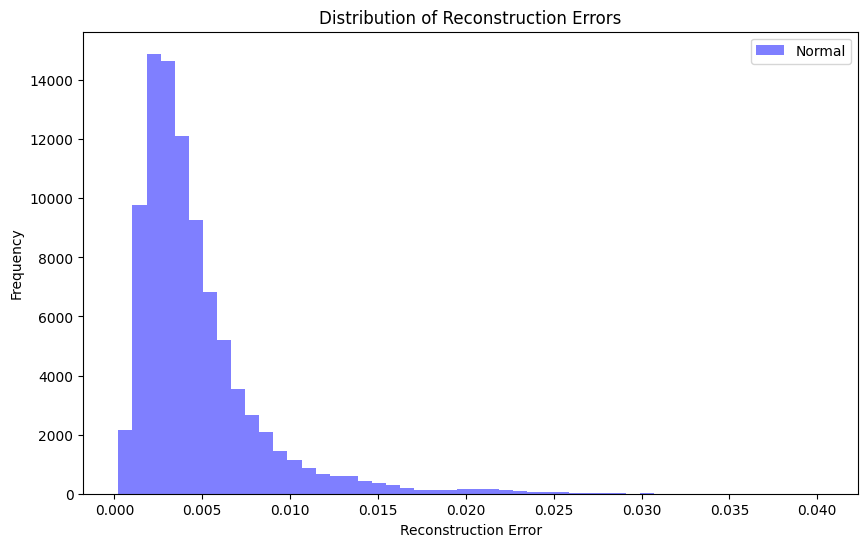

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_losses, bins=50, alpha=0.5, color="blue", label="Normal")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.savefig('temp/normal.png')

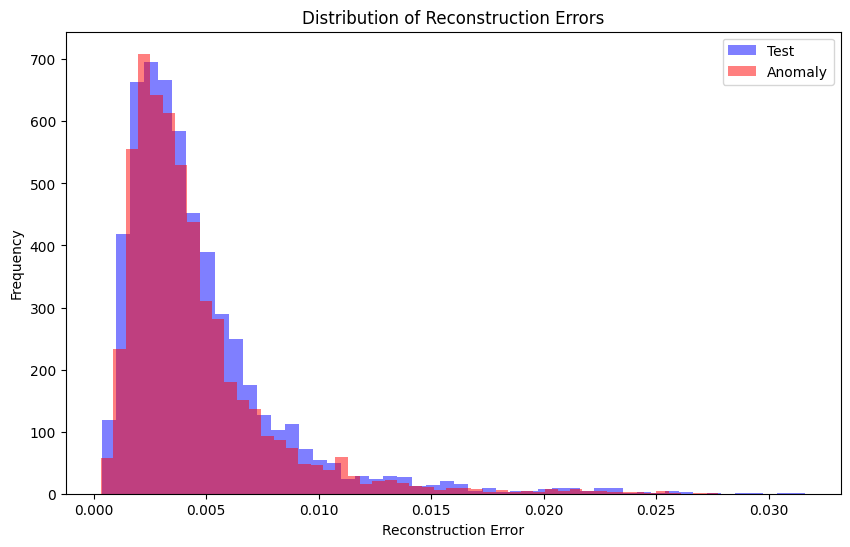

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_test_errors, bins=50, alpha=0.5, color="blue", label="Test")
plt.hist(anomaly_test_errors, bins=50, alpha=0.5, color="red", label="Anomaly")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.savefig('temp/test.png')